In [1]:
%load_ext autoreload
%autoreload 2

# Setup

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

from deepexperiment.utils import one_hot_encoding, one_hot_encoding_batch, ResBlock, get_indices
from deepexperiment.interpret import DeepShap
from deepexperiment.visualization import plot_cluster

2022-12-08 13:07:02.767991: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/katarina/Documents/repositories/GitHub/DeepExperiment/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Loading model and data

In [3]:
model = keras.models.load_model("../models/miRBind.h5")

2022-12-08 13:07:13.239009: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
samples = pd.read_csv('../data/positive_set_extended.csv')
print(len(samples))

18513


In [5]:
data, _ = one_hot_encoding_batch(samples)

# DeepSHAP

In [6]:
rand_samples = samples.sample(n=100, replace=False, random_state=42).reset_index(drop=True)
background, _ = one_hot_encoding_batch(rand_samples)
shaps = []

for i in range((len(data) // 1000) + 1):
    filename = f'../data/positive_set_shaps_{i}.npy'
    try:
        shap = np.load(filename)
        shaps.extend(shap)
        print(f'{filename} file exists.')
    except:
        print(f'{filename} file not found.')
        deepShap = DeepShap(model, background)
        data_sample = data[i*1000:(i+1)*1000]
        attribution = deepShap(data_sample)
        pos_shaps = attribution[1][:,:,:,0]
        shap = np.array(pos_shaps)
        shaps.extend(shap)
        np.save(filename, shaps)

../data/positive_set_shaps_0.npy file exists.
../data/positive_set_shaps_1.npy file exists.
../data/positive_set_shaps_2.npy file exists.
../data/positive_set_shaps_3.npy file exists.
../data/positive_set_shaps_4.npy file exists.
../data/positive_set_shaps_5.npy file exists.
../data/positive_set_shaps_6.npy file exists.
../data/positive_set_shaps_7.npy file exists.
../data/positive_set_shaps_8.npy file exists.
../data/positive_set_shaps_9.npy file exists.
../data/positive_set_shaps_10.npy file exists.
../data/positive_set_shaps_11.npy file exists.
../data/positive_set_shaps_12.npy file exists.
../data/positive_set_shaps_13.npy file exists.
../data/positive_set_shaps_14.npy file exists.
../data/positive_set_shaps_15.npy file exists.
../data/positive_set_shaps_16.npy file exists.
../data/positive_set_shaps_17.npy file exists.
../data/positive_set_shaps_18.npy file exists.


In [8]:
from deepexperiment.alignment import Attrament

attrament = Attrament()
align_x, align_s, align_y = [], [], []
for index, attr in enumerate(shaps):
    x, s, y = attrament(samples.iloc[index]['miRNA'][::-1], samples.iloc[index]['gene'], attr)
    align_x.append(x)
    align_s.append(s)
    align_y.append(y)

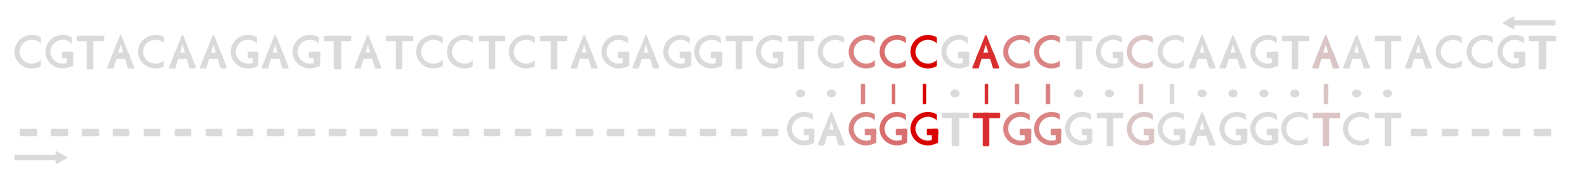

In [9]:
from deepexperiment.visualization import plot_alignment

plot_alignment(align_x[2], align_s[2], align_y[2])

# Clustering

In [12]:
miRNA_s = []
for j in range(len(align_y)):
    s = [align_s[j][i] for i in range(len(align_y[j])) if align_y[j][i] != "-"]
    # pad with zeros to the length of 20
    if len(s) < 20:
        s = s + [0] * (20 - len(s))
    miRNA_s.append(s)

miRNA_s = np.array(miRNA_s)

In [13]:
from sklearn.cluster import KMeans

N_CLUSTERS=5
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42)
kmeans.fit(miRNA_s)

KMeans(n_clusters=5, random_state=42)

In [14]:
labels = kmeans.labels_
labels

array([4, 3, 2, ..., 0, 4, 0], dtype=int32)

(array([4050., 3263., 4641., 3156., 3403.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. ]),
 <BarContainer object of 5 artists>)

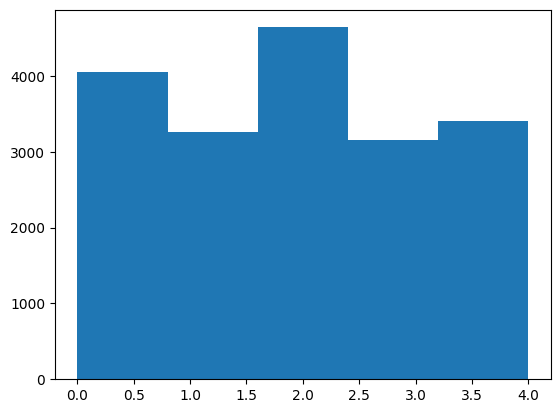

In [15]:
plt.hist(labels,bins=N_CLUSTERS)

# Visualization

In [16]:
from deepexperiment.clustering import compute_cluster_consensus

cluster_consensus = compute_cluster_consensus(miRNA_s, labels)

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


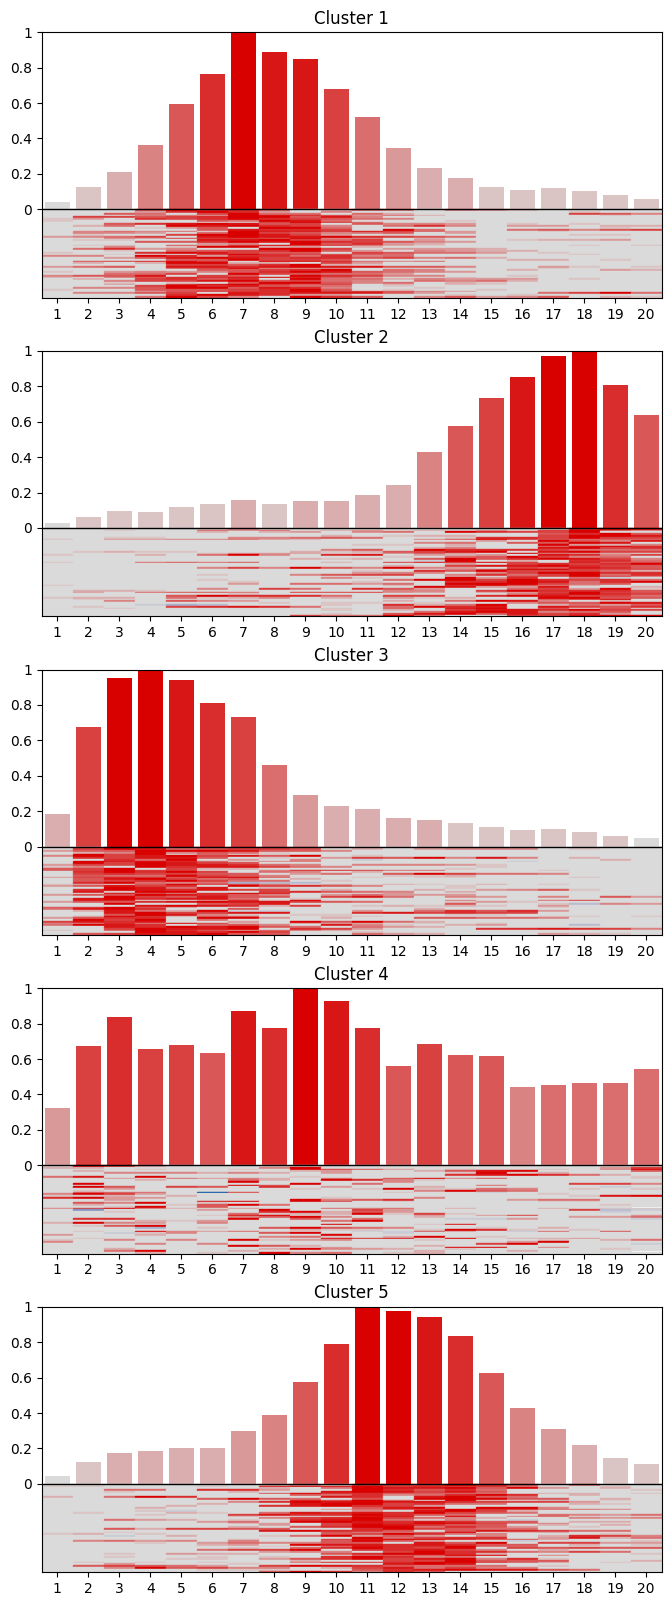

In [17]:
align_y = np.array(align_y, dtype=object)
align_s = np.array(align_s, dtype=object)

fig, ax = plt.subplots(5, 1, figsize=(8, 20))

for cluster in range(5):
    plot_cluster(ax[cluster],  align_y[labels == cluster], align_s[labels == cluster], cluster_consensus[cluster], f"Cluster {cluster + 1}")

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


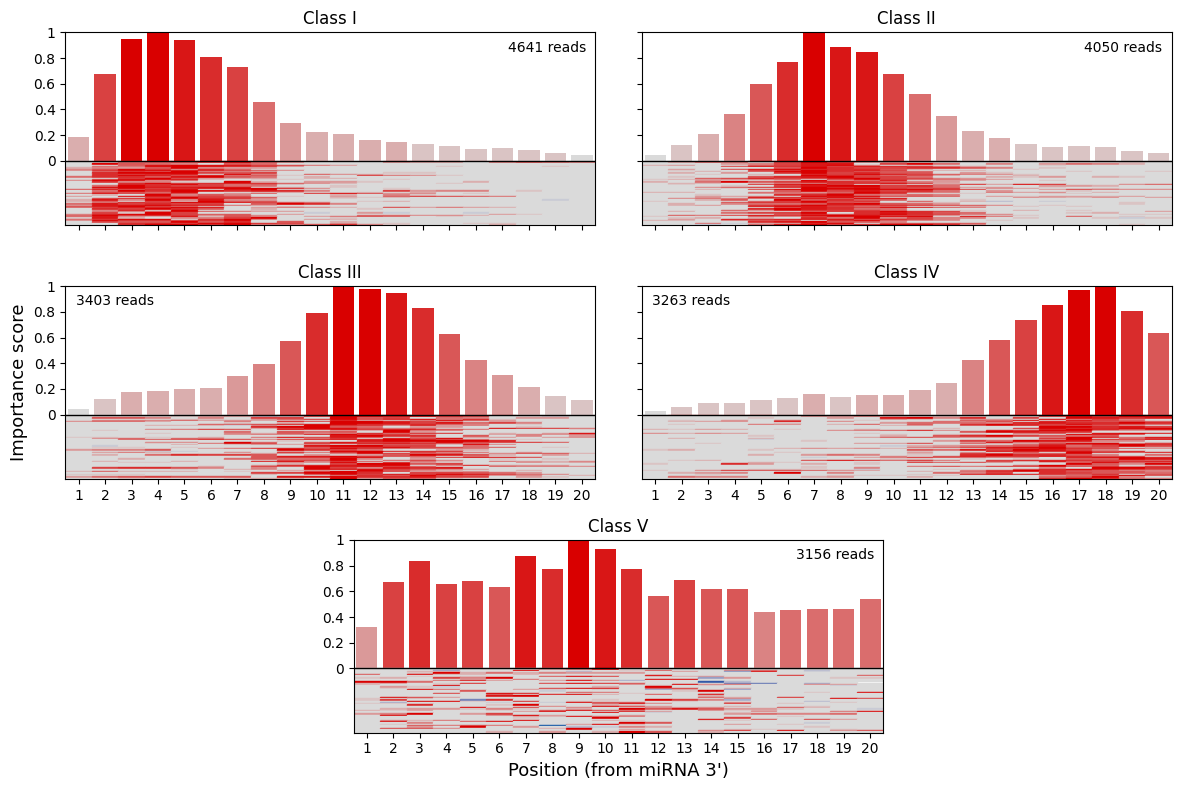

In [48]:
fig = plt.figure(figsize=(12,8))
ax = [0] * 5

ax[0] = plt.subplot2grid(shape=(3,4), loc=(0,0), colspan=2)
ax[1] = plt.subplot2grid((3,4), (0,2), colspan=2)
ax[2] = plt.subplot2grid((3,4), (1,0), colspan=2)
ax[3] = plt.subplot2grid((3,4), (1,2), colspan=2)
ax[4] = plt.subplot2grid((3,4), (2,1), colspan=2)


plot_cluster(ax[0], align_y[labels == 2], align_s[labels == 2], cluster_consensus[2], "Class I")
ax[0].text(17.2, 0.85, "4641 reads")
ax[0].set_xticklabels([])

plot_cluster(ax[1], align_y[labels == 0], align_s[labels == 0], cluster_consensus[0], "Class II")
ax[1].text(17.2, 0.85, "4050 reads")
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])

plot_cluster(ax[2], align_y[labels == 4], align_s[labels == 4], cluster_consensus[4], "Class III")
ax[2].set_ylabel('Importance score', size=13)
ax[2].text(0.9, 0.85, "3403 reads")

plot_cluster(ax[3], align_y[labels == 1], align_s[labels == 1], cluster_consensus[1], "Class IV")
ax[3].text(0.9, 0.85, "3263 reads")
ax[3].set_yticklabels([])

plot_cluster(ax[4], align_y[labels == 3], align_s[labels == 3], cluster_consensus[3], "Class V")
ax[4].set_xlabel('Position (from miRNA 3\')', size=13)
ax[4].text(17.2, 0.85, "3156 reads")

plt.subplots_adjust(hspace=0.2, wspace=0.5)
plt.tight_layout()

plt.plot();